# Explore DRAGON results

# 1. Initialisation

## System

In [1]:
#%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import os

from astropy.io import fits

In [2]:
data_dir = 'Data_files'  # observational data
output_dir = 'output'  # DRAGON runs

## Utility functions

In [3]:
'''
particle_names = {
    'Z=-1_A=0': r'e$^-$',
    'Z=1_A=0': r'e$^+$',
    'Z=-1_A=1': r'$\bar{p}$',
    'Z=1_A=1': r'p',
    'Z=1_A=2': r'$^2$H',
    'Z=1_A=3': r'$^3$H',
    'Z=2_A=3': r'$^3$He',
    'Z=2_A=4': r'$^4$He',
}
particle_groups = {
    'H': ['p', r'$^2$H', r'$^3$H'],
    'He': [r'$^4$He', r'$^3$He'],
}
n_groups = len(particle_groups)
'''

"\nparticle_names = {\n    'Z=-1_A=0': r'e$^-$',\n    'Z=1_A=0': r'e$^+$',\n    'Z=-1_A=1': r'$\x08ar{p}$',\n    'Z=1_A=1': r'p',\n    'Z=1_A=2': r'$^2$H',\n    'Z=1_A=3': r'$^3$H',\n    'Z=2_A=3': r'$^3$He',\n    'Z=2_A=4': r'$^4$He',\n}\nparticle_groups = {\n    'H': ['p', r'$^2$H', r'$^3$H'],\n    'He': [r'$^4$He', r'$^3$He'],\n}\nn_groups = len(particle_groups)\n"

In [4]:
element_name = ['leptons', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O']

def species_name(Z, A):
    if A == 0:
        if Z == -1:
            return r'e$^-$'
        elif Z == 1:
            return r'e$^+$'
        else:
            print(f'WARNING: Unknown particle: Z={Z}, A={A}')
            return f'Z={Z}, A={A}'
    elif A == 1:
        if Z == -1:
            return r'$\bar{p}$'
        elif Z == 1:
            return 'p'
        else:
            print(f'WARNING: Unknown particle: Z={Z}, A={A}')
            return f'Z={Z}, A={A}'
    else:
        return f'$^{{{A}}}${element_name[Z]}'


# 2. Read data

## Observations

In [24]:
class Dataset(object):
    
    def __init__(self, name, Z, A, symbol, file_name, cols, skiprows=0, errx='error', erry='error', alpha_norm=0, rigidity=False):
        self.name = name
        self.Z = Z
        self.A = A
        self.symbol = symbol
        file_name = os.path.join(data_dir, file_name)
        self.E, self.dE_low, self.dE_up, self.F, self.dF_low, self.dF_up = np.loadtxt(file_name, skiprows=skiprows, usecols=cols, unpack=True)

        if errx == 'limit':
            self.dE_low = self.E - self.dE_low
            self.dE_up = self.dE_up - self.E
        elif errx != 'error':
            print(f'WARNING: I do not understand errx = "{errx}"')
        if erry == 'limit':
            self.dF_low = self.F - self.dF_low
            self.dF_up = self.dF_up - self.F
        elif erry != 'error':
            print(f'WARNING: I do not understand erry = "{erry}"')

        if rigidity:
            self.R_to_Kn()

        norm = np.power(self.E, alpha_norm)
        self.F /= norm
        self.dF_low /= norm
        self.dF_up /= norm


    def R_to_Kn(self):
        """Convert rigidity [GV] to kinetic energy per nucleon [GeV]"""
        # m = 0.9315
        mp = 0.93827209  # proton mass, in GeV

        R = np.array(self.E)
        Kn = (np.sqrt((self.Z*R/self.A)**2 + mp**2) - mp )
        factor = Kn/self.E
        self.E *= factor
        self.dE_low *= factor
        self.dE_up *= factor
        
        # (ZR/A)² = (Kn+mp)² - mp² = Kn * (Kn + 2*mp)
        dRdKn = self.A * (Kn + mp) / (self.Z*R)
        self.F *= dRdKn
        self.dF_low *= dRdKn
        self.dF_up *= dRdKn


    def plot(self, Z, A, alpha_norm, ax):
        if Z == self.Z and A == self.A:
            norm = np.power(self.E, alpha_norm)
            ax.errorbar(self.E, norm*self.F,
                        xerr=[self.dE_low, self.dE_up],
                        yerr=[norm*self.dF_low, norm*self.dF_up],
                        fmt=self.symbol, label=self.name)


In [25]:
measurements = []

measurements.append(Dataset('Voyager', 1, 1, 'y^', 'Voyager1_2012_Proton.dat', (0, 1, 2, 3, 8, 9), errx='limit'))
measurements.append(Dataset('Voyager', 2, 4, 'y^', 'Voyager_He_2012.dat', (0, 1, 2, 3, 8, 9), errx='limit'))
'''
d = Dataset('Voyager (2012-15)', 2, 4, 'yv', 'Voyager1_Helium.txt', (2, 0, 1, 3, 4, 5), skiprows=5, errx='limit')
# unsure about columns, but MeV -> GeV
d.E /= 1e3
d.dE_low /= 1e3
d.dE_up /= 1e3
d.F *= 1e3
d.dF_low *= 1e3
d.dF_up *= 1e3
measurements.append(d)
'''

measurements.append(Dataset('AMS', 1, 1, 'c.', 'prot_AMS_2011-2013.dat', (0, 1, 2, 3, 8, 9), errx='limit'))
measurements.append(Dataset('AMS', -1, 1, 'c.', 'Antip_AMS_2011-2015.dat', (0, 1, 2, 3, 8, 9), errx='limit'))
measurements.append(Dataset('AMS', 2, 4, 'c.', 'He_AMS_2011-2013.dat', (0, 1, 2, 3, 8, 9), errx='limit'))
measurements.append(Dataset('AMS', 3, 6, 'c.', 'Li_AMS_PRL2018.txt', (0, 1, 2, 3, 4, 5), errx='limit'))
measurements.append(Dataset('AMS', 4, 8, 'c.', 'Be_AMS_PRL2018.txt', (0, 1, 2, 3, 4, 5), errx='limit'))
measurements.append(Dataset('AMS', 5, 10, 'c.', 'B_AMS_PRL2018.txt', (0, 1, 2, 3, 4, 5), errx='limit'))
measurements.append(Dataset('AMS', 6, 12, 'c.', 'C_AMS_PRL2017.txt', (0, 1, 2, 3, 4, 5), errx='limit'))
measurements.append(Dataset('AMS', 7, 14, 'c.', 'N_AMS_PRL2018_rig.txt', (0, 1, 2, 3, 4, 5), errx='limit', rigidity=True))
measurements.append(Dataset('AMS', 8, 16, 'c.', 'O_AMS_PRL2017.txt', (0, 1, 2, 3, 4, 5), errx='limit'))

measurements.append(Dataset('ATIC', 1, 1, 'cx', 'p_flux_ATIC2009.txt', (0, 1, 2, 3, 4, 5), alpha_norm=2.7))
measurements.append(Dataset('CREAM', 1, 1, 'g*', 'p_flux_CREAMIII_ApJ2017.txt', (0, 1, 2, 3, 4, 5)))
measurements.append(Dataset('DAMPE', 1, 1, 'rs', 'DAMPE_protons.txt', (1, 0, 2, 3, 4, 5), skiprows=1, errx='limit', erry='limit'))


In [7]:
'''
myZ = 6
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA
'''


"\nmyZ = 6\ndata = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') \nZ, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)\nfluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)\nEmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]\nerrfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]\nfluxA = 1e3*fluxA[Z==myZ]\n\nEmean_min = (1e-3 * Emean_min[Z==myZ])\nEmean_max = (1e-3 * Emean_max[Z==myZ])\n\nEmean_min = EmeanA - Emean_min\nEmean_max = Emean_max - EmeanA\n\nEmeanA = EmeanA\n"

In [8]:
'''
data = os.path.join(data_dir, 'O_AMS_PRL2017.txt') 
EmeanO, EmeanO_low, EmeanO_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxO, fluxO_low, fluxO_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)

errfluxO = (fluxO_low + fluxO_up)/2

myZ = 8
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA
'''


"\ndata = os.path.join(data_dir, 'O_AMS_PRL2017.txt') \nEmeanO, EmeanO_low, EmeanO_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)\nfluxO, fluxO_low, fluxO_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)\n\nerrfluxO = (fluxO_low + fluxO_up)/2\n\nmyZ = 8\ndata = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') \nZ, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)\nfluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)\nEmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]\nerrfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]\nfluxA = 1e3*fluxA[Z==myZ]\n\nEmean_min = (1e-3 * Emean_min[Z==myZ])\nEmean_max = (1e-3 * Emean_max[Z==myZ])\n\nEmean_min = EmeanA - Emean_min\nEmean_max = Emean_max - EmeanA\n\nEmeanA = EmeanA\n"

In [9]:
'''
data = os.path.join(data_dir, 'B_C_ratio_AMS_PRL2018.txt')
EmeanBC = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxBC, fluxBC_low, fluxBC_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)
errfluxBC = (fluxBC_low + fluxBC_up)/2


## Voyager data
def voyerr(a, b, da, db):
    if ((type(a) != np.ndarray) or (type(b) != np.ndarray) or 
        (type(da) != np.ndarray) or (type(db) != np.ndarray)):
        print("Error, the Fluxes (Energies) and errFluxes (ErrEnergies) must be an array")
    return np.sqrt((da/b)**2 + (-a*db/b**2)**2)


MyZ = 6
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 5
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBC)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)
'''


'\ndata = os.path.join(data_dir, \'B_C_ratio_AMS_PRL2018.txt\')\nEmeanBC = np.loadtxt(data,skiprows=0,usecols=(0,))\nfluxBC, fluxBC_low, fluxBC_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)\nerrfluxBC = (fluxBC_low + fluxBC_up)/2\n\n\n## Voyager data\ndef voyerr(a, b, da, db):\n    if ((type(a) != np.ndarray) or (type(b) != np.ndarray) or \n        (type(da) != np.ndarray) or (type(db) != np.ndarray)):\n        print("Error, the Fluxes (Energies) and errFluxes (ErrEnergies) must be an array")\n    return np.sqrt((da/b)**2 + (-a*db/b**2)**2)\n\n\nMyZ = 6\ndata = os.path.join(data_dir, \'apjaa2409t9_ascii.txt\') \nZ, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)\nfluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)\nEmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]\n\nerrfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]\nfluxA2 = 1e3*fluxA2[Z==MyZ]\n\nerrfluxA2 = (errfluxA2[EmeanA2 > 0.01])\nfluxA2 = fluxA2[Eme

## DRAGON output

In [35]:
class DRAGON_run(object):
    
    def __init__(self, model_name):
        self.hdulist = None
        self.read(model_name)

    def read(self, model_name):
        if self.hdulist is not None:
            self.hdulist.close()
        print('Reading DRAGON model:', model_name)
        self.hdulist = fits.open(os.path.join(output_dir, f'{model_name}.fits.gz'))
        #hdulist.info()
        self.name = model_name

        h = self.hdulist[0].header
        #for key in h:
        #    print(f'{key:10s} = {h[key]}')
        self.grid_E = np.logspace(np.log10(h['EKMIN']), np.log10(h['EKMAX']), h['NAXIS1'])
        self.grid_R = np.linspace(h['RMIN'], h['RMAX'], h['NAXIS2'])
        self.grid_z = np.linspace(h['ZMIN'], h['ZMAX'], h['NAXIS3'])
        self.izsun = h['izsun']
        self.irsun = h['irsun']
        #print(f"(R, z)_sun = ({grid_R[irsun]}, {grid_z[izsun]}) ~ ({h['robs']}, {h['zobs']})")

        print('  Z   A  origin   max_flux')
        for hdu in self.hdulist[1:]:
            if hdu.header['SEC']:
                origin = "secondary"
            elif hdu.header['DM']:
                origin = "   DM    "
            elif hdu.header['EXTRA']:
                origin = "  extra  "
            else:
                origin = " primary "
            print(f"{hdu.header['Z_']:3} {hdu.header['A']:3} {origin} {np.max(hdu.data):g}")


    def get_local_spectrum(self, Z=None, A=None, origin=None):
        spectrum = np.zeros_like(self.grid_E)
        for hdu in self.hdulist[1:]:
            #print(hdu.header['Z_'], hdu.header['A'], hdu.header['SEC'], hdu.header['DM'], hdu.header['EXTRA'])
            match = True
            if Z is not None:
                match &= (Z == hdu.header['Z_'])
            if A is not None:
                match &= (A == hdu.header['A'])
            if origin is not None:
                if hdu.header['SEC']:
                    match &= (origin == "secondary")
                elif hdu.header['DM']:
                    match &= (origin == "DM")
                elif hdu.header['EXTRA']:
                    match &= (origin == "extra")
                else:
                    match &= (origin == "primary")
            if match:
                spectrum += hdu.data[self.izsun, self.irsun]
        return spectrum


    def plot_map(self, species, E, ax):
        energy = np.searchsorted(self.grid_E, E)
        data = self.spectra[species][:, :, energy]
        p1, p99 = np.nanpercentile(data, [1, 99])
        im = ax.imshow(data,
                       extent=(self.grid_R[0], self.grid_R[-1], self.grid_z[0], self.grid_z[-1]),
                       origin='lower', interpolation='nearest',
                       cmap='inferno',
                       norm=colors.LogNorm(vmin=max(p1, 1e-4*p99), vmax=p99),
                      )
        ax.set_aspect('auto')
        ax.scatter(self.grid_R[self.irsun], self.grid_z[self.izsun], s=5, color='k')
        ax.scatter(self.grid_R[self.irsun], self.grid_z[self.izsun], s=50, facecolor='none', edgecolor='k')
        cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=.2)
        ax.legend(title=self.name, loc='upper center')



In [36]:
#model_names = ['run_2D_DM_0', 'run_2D_DM_1', 'run_2D_DM_2']
#model_names = ['run_2D_DM', 'run_2D_DM_Delta=0.4', 'run_2D_DM_Delta=0.8']
model_names = ['test_model']
models = []
for name in model_names:
    models.append(DRAGON_run(name))
n_models = len(models)

Reading DRAGON model: test_model
  Z   A  origin   max_flux
  1   0 secondary 6917.81
 -1   0  primary  291201
 -1   0 secondary 2175.57
 -1   0   extra   411.198
  1   1 secondary 4774.36
  1   1  primary  90606
  1   2  primary  0
  2   3  primary  4.85655
  1   3  primary  0
  2   4  primary  9183.59
  3   6  primary  7.08938
  3   7  primary  6.14039
  3   8  primary  0
  3   9  primary  0
  4   7  primary  3.33709
  4   9  primary  1.77092
  5  10  primary  5.86788
  4  10  primary  0.184136
  5  11  primary  13.7991
  5  12  primary  0
  5  13  primary  0
  5  14  primary  0
  6  10  primary  0
  6  11  primary  0
  6  12  primary  123.799
  6  13  primary  3.23197
  6  15  primary  0
  6  16  primary  0
  7  14  primary  7.81453
  6  14  primary  0.000647817
  7  15  primary  6.18356
  8  16  primary  121.509
  8  17  primary  0.061266
  8  18  primary  0.0368242
  9  18  primary  0
  9  19  primary  5.2959e-10
 10  20  primary  5.42494
 10  21  primary  6.39764e-05
 10  22  pri

# 2. Plots

In [12]:
phi_ams = 0.7  ## Fisk potential adopted to make the plots


def modulation(E, flux, Z, A, phi_nuc, Charge_sign=False, phi_n= 0.7, fluxerr = 0):  ##IMPLEMENTED FOR THE FORCE-FIELD APPROX WITH THE MODIFICATION OF 
                                                                                ##CHOLIS-HOOPER-LINDEN (arXiv:1511.01507) FOR CHARGE-SIGN DEPENDENCE
    m_p = 0.9383                      # proton mass in GeV/c^2
    m_u = 0.9315                      # atomic mass in GeV/c^2
    m_e = 0.000510998918            # electron mass in GeV/c^2
    if Z==1 and A==1:
        m = m_p
    else:
        m = m_u

    E = np.array(E)

    if Charge_sign == True:         
        R0 = 1.
        R = (A/Z) * np.sqrt(E**2 + 2*m*E)
        phi_ = phi_n
        phi_n = phi_nuc + phi_*(R0/R)
        En = E + (Z/A)*phi_n
        mod = E * (E + 2*m) / ((E + (Z/A)*phi_n + m)**2 - m**2)
        flux_mod = np.interp(En, E, flux)*mod

    else:
        En = E + (Z/A)*phi_nuc
        mod = E * (E + 2*m) / ((E + (Z/A)*phi_nuc + m)**2 - m**2)
        flux_mod = np.interp(En, E, flux)*mod

    if fluxerr != 0: 
        fluxerr_mod = np.interp(En, E, fluxerr)*mod
        return np.array(flux_mod), np.array(fluxerr_mod)

    return np.array(flux_mod)#, np.array(fluxerr_mod)


Reading DRAGON model: test_model
  Z   A  origin   max_flux
  1   0 secondary 6425.77
 -1   0  primary  286704
 -1   0 secondary 2054.41
 -1   0   extra   449.514
 -1   1 secondary 0.0307906
 -1   1  primary  0.0876289
  1   1 secondary 2612.45
  1   1  primary  66894.9
  1   2  primary  0
  2   3  primary  2.797
  1   3  primary  0
  2   4  primary  6666.28
  3   6  primary  4.08813
  3   7  primary  3.48649
  3   8  primary  0
  3   9  primary  0
  4   7  primary  2.07051
  4   9  primary  1.07007
  5  10  primary  3.67022
  4  10  primary  0.116854
  5  11  primary  8.65115
  5  12  primary  0
  5  13  primary  0
  5  14  primary  0
  6  10  primary  0
  6  11  primary  0
  6  12  primary  100.92
  6  13  primary  2.06398
  6  15  primary  0
  6  16  primary  0
  7  14  primary  5.79408
  6  14  primary  0.000562874
  7  15  primary  4.12143
  8  16  primary  102.462
  8  17  primary  0.000494309
  8  18  primary  0.0247613


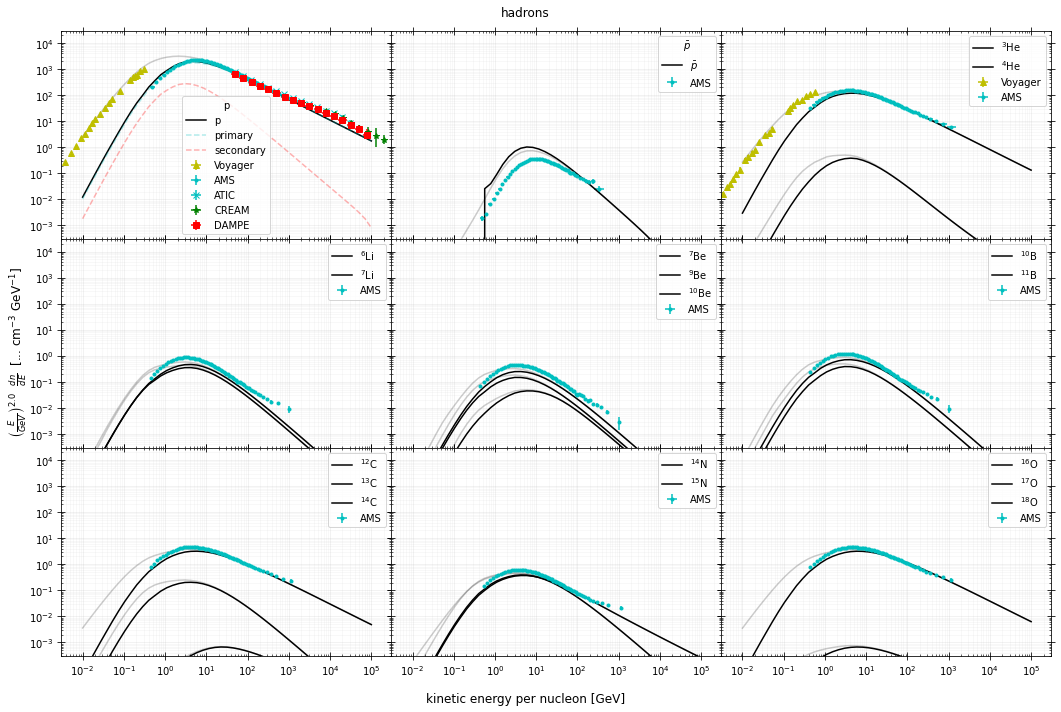

In [83]:
for model in models:
    model.read(model.name)
phi_ams = .5  ## Fisk potential adopted to make the plots

alpha_norm = 2.
color = {'primary': 'b', 'secondary': 'r', 'DM': 'k', 'extra': 'k'}
style = ['-', '--', ':', '-.']

def plot_models(ax, style, Z, A, origin=None):
    for i, model in enumerate(models):
        norm = np.power(model.grid_E, alpha_norm)
        data = model.get_local_spectrum(Z, A, origin)
        if np.nanmax(data) > 0:
            if origin is None:
                #label = model.name
                label = species_name(Z, A)
                ax.plot(model.grid_E, norm*data, style, alpha=.2)
                alpha = 1
            else:
                #label = f'{origin} {species_name(Z, A)}'
                label = origin
                alpha = .3
            ax.plot(model.grid_E, norm*modulation(model.grid_E, data, Z, A, phi_ams),
                    style, label=label, alpha=alpha)


def plot_species(ax, Z, A):
    for dataset in measurements:
        dataset.plot(Z, A, alpha_norm, ax)

    plot_models(ax, 'k-', Z, A)

def plot_element(ax, Z):
    for A in range(1, 3*Z):
        for dataset in measurements:
            dataset.plot(Z, A, alpha_norm, ax)
        plot_models(ax, 'k-', Z, A)
    ax.legend()


fig_name = 'hadrons'
plt.close(fig_name)

nrows = 3
ncols = 3
panel_size = min(10/nrows, 15/ncols)
fig = plt.figure(fig_name, figsize=(ncols*panel_size*1.5, nrows*panel_size))
axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(fig_name)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.2)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_yscale('log')
plot_species(ax, 1, 1)
plot_models(ax, 'c--', 1, 1, 'primary')
plot_models(ax, 'r--', 1, 1, 'secondary')
ax.legend(title='p')

ax = axes[0, 1]
ax.set_yscale('log')
plot_species(ax, -1, 1)
ax.legend(title=r'$\bar{p}$')

ax = axes[0, 2]
ax.set_yscale('log')
plot_element(ax, 2)


ax = axes[1, 0]
ax.set_yscale('log')
plot_element(ax, 3)
#ax.legend(title='Li')

ax = axes[1, 1]
ax.set_yscale('log')
plot_element(ax, 4)
#ax.legend(title='Be')

ax = axes[1, 2]
ax.set_yscale('log')
plot_element(ax, 5)
#plot_species(ax, 5, 10)
#ax.legend(title='B')


ax = axes[2, 0]
ax.set_yscale('log')
plot_element(ax, 6)
#plot_species(ax, 6, 12)
#ax.legend(title='C')

ax = axes[2, 1]
ax.set_yscale('log')
plot_element(ax, 7)
#plot_species(ax, 7, 14)
#ax.legend(title='N')

ax = axes[2, 2]
ax.set_yscale('log')
plot_element(ax, 8)
#plot_species(ax, 8, 16)
#ax.legend(title='O')


ax.set_ylim(3e-4, 3e4)
ax.set_xlim(3e-3, 3e5)
ax.set_xscale('log')

#fig.supylabel(f'(E/GeV)$^{alpha_norm}$ dn/dE [... cm$^{{-3}}$ GeV^{{-1}}$]')
fig.supylabel(f'$\\left(\\frac{{E}}{{GeV}}\\right)^{{{alpha_norm}}}$  $\\frac{{dn}}{{dE}}$  [... cm$^{{-3}}$ GeV$^{{-1}}$]')
fig.supxlabel('kinetic energy per nucleon [GeV]')
#for ax in axes[-1, :]:
#    ax.set_xlabel('kinetic energy per nucleon [GeV]')
plt.show()

In [14]:
models[0].get_local_spectrum(-1, 1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
data

NameError: name 'data' is not defined

## Map

In [ ]:
fig_name='map'
plt.close(fig_name)

panel_size = 8/n_models
fig = plt.figure(fig_name, figsize=(np.clip(2*panel_size, 4, 12), 8))
axes = fig.subplots(nrows=n_models, ncols=1, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )

species = 'primary e$^-$'
energy = 1e3
fig.suptitle(f'{species}, E={energy} GeV')

for i, model in enumerate(models):
    ax = axes[i, 0]
    model.plot_map(species, energy, ax)
    ax.set_ylabel('z [kpc]')

axes[-1, 0].set_xlabel('R [kpc]')
plt.show()

proton spectrum

In [ ]:
[m.name for m in measurements]

In [ ]:
measurements[3].E, measurements[3].F

In [ ]:
measurements[4].E, measurements[4].F

In [81]:
model.hdulist[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                   49 / length of data axis 1                          
NAXIS2  =                   25 / length of data axis 2                          
NAXIS3  =                   49 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
Z_      =                    1                                                  
A       =                    0                                                  
SEC     =                    1                                                  
DM      =                    0                                                  
EXTRA   =                   